<h1 style="color: blue; text-align:center">Evaluating the Role of Chunk Size in Retrieval-Augmented Generation (RAG)</h1>


<h2 style="text-align:center;color:green">Methodology<h2>

## RAG Architecture

![](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Ff90434a2-7f75-4c16-8461-d1efed5939d0_1380x730.png)

### import required libraries

In [54]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
import requests
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
import os
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
import json
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import re
from bert_score import score


# Preparing the Knowledge Base

## Select Dataset

The **"christti/squad-augmented-v2"** dataset builds on the Stanford Question Answering Dataset (SQuAD) and includes diverse, human-curated passages with associated questions and answers. It provides rich, semantically coherent contexts spanning various topics, making it ideal for tasks like question answering and retrieval-based systems.

## Why this Dataset
 + **Diverse Topics:** The dataset covers a wide range of subjects, ensuring a comprehensive and heterogeneous knowledge base.
 + **Rich Contexts:** High-quality passages are well-suited for chunking experiments without losing semantic integrity.
 + **Real-World Relevance:** Designed around real-world use cases, it aligns closely with typical RAG applications.
 + **Benchmark Quality:** Widely recognized in NLP research, it ensures credibility and comparability of results.
 + **Ease of Use:** Its structured format simplifies preprocessing and knowledge base construction.

## Construct the corpus

### import the dataset

In [3]:
ds = load_dataset("christti/squad-augmented-v2")
df = pd.DataFrame(ds["train"])

In [7]:
df.shape

(169211, 5)

In [7]:
df['context'].unique().shape

(100132,)

the dataset contains huge number of rows. for the limitation of computational power we use only first **5000** rows from the dataset.

In [8]:
df = pd.DataFrame(ds["train"][:5000])
df.head(3)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."


Each row contains  **context**, **question** and **answer**

### Select first 820 contexts

In [9]:
contexts = df['context'].unique()

In [10]:
contexts.shape

(820,)

there are 820 different contexts

### Concatenate all the contexts to create a unified knowledge base or corpus.

In [12]:
corpus = ' '.join([context for context in contexts])

In [14]:
len(corpus)

600535

In [15]:
len(corpus.split(" "))

96449

96449 words

## Chunking Strategy

## Select Chunk Size

Now the corpus will be divided into different chunk size. We will consider 4 type of chunk type.
   + page
   + small 
   + medium 
   + large 

in the dataset we have seen each row has a context. so we will consider each context as a page. this is also one of the popular chunking strategy. for getting optimal chunk size for **small, medium and large** let analyse the length of each context.  

### Analyze length of contexts
For the sake of defining chunk sizes for small, medium, and large, the lengths of contexts in the dataset were analyzed.<br>
A descriptive statistical analysis of the character lengths was performed, which reveals the following:

In [22]:
pd.Series(df['context'].unique()).str.len().describe()

count     820.000000
mean      731.360976
std       358.499497
min       154.000000
25%       468.750000
50%       667.000000
75%       912.500000
max      3076.000000
dtype: float64

Based on the analysis: <br>
**Small Chunk:** ~250–500 characters. This covers short passages, ideally capturing documents around the 25th percentile.<br>
**Medium Chunk:** ~500–800 characters. This aligns with documents near the mean and median length.<br>
**Large Chunk:** ~800–1,200 characters or even up to 1,500 characters. This range would cover longer documents that approach the 75th percentile or exceed the mean.<br>
**Set Chunk Overlaps:** Since we may need overlapping text for context (e.g., sentence continuity), we use overlaps of around 10–20% of each chunk size:<br>
**Small chunks:** ~50–100 characters overlap<br>
**Medium chunks:** ~100–150 characters overlap<br>
**Large chunks:** ~150–200 characters overlap<br>

## Store all the chunks of each chunk type in a table in Database

### create chunks for each chunk size

<code>get_chunks_by_size()</code> function is used to devide the **knowledge base or corpus** into chunks of given chunk size and  overlap.

In [ ]:
def get_chunks_by_size(chunk_size: int, overlap: int, corpus: str):
    chunk_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=overlap
    )
    return chunk_splitter.split_text(corpus)

## Table for storing chunks in DB
I have created a table in my local Database for storing all the chunks of each chunk type and their corresponding embeddings. The database table looks like, 

### Table: text_vectors

| Field      | Type                                  | Null | Key | Default | Extra          |
|------------|---------------------------------------|------|-----|---------|----------------|
| id         | int                                   | NO   | PRI | NULL    | auto_increment |
| chunk_text | text                                  | YES  |     | NULL    |                |
| chunk_type | enum('PAGE','SMALL','MEDIUM','LARGE') | NO   |     | NULL    |                |
| embedding  | blob                                  | YES  |     | NULL    |                |


## Calculate embeddings for each chunk
After getting chunks from <code>get_chunks_by_size()</code> function, we can calculate their embeddings. But before calculating embeddings one of the most important step is **Text Preprocessing**. The following steps are included in **Text Preprocessing**.

### Text Preprocessing

In [25]:
def text_preprocessing(text):
    """
    Apply all preprocessing functions to the input text.
    """
    # Step 1: Remove HTML tags
    text = removeHTMLTags(text)
    
    # Step 2: Remove URLs
    text = removeURL(text)
    
    # Step 3: Remove punctuation
    text = remove_punctuation(text)
    
    # Step 4: Remove stopwords
    text = remove_stopwords(text)
    
    # Step 5: stemming
    text = stem_word(text)
    
    # Step 6: lemmatization
    text = lemmatize_text(text)
    return text

After text preprocessing the chunks are ready to be converted into vector. <code>get_embeddings()</code> function is used to calculate embeddings for each chunk.

In [ ]:
def get_embeddings(text):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    vector = model.encode(text)
    pickled_vector = pickle.dumps(vector)
    return pickled_vector

After calculating embeddings all the chunks are stored in <code>text_vectors</code> table in local database.

## Analyze Stored chunks in Database

### Get all the chunks from the Database and convert them into pandas Dataframe

In [32]:
url = "http://172.24.0.127:8080/app/get/chunks"
response = requests.get(url)
response.raise_for_status() 
data = response.json() 
chunks = pd.DataFrame(data) 


In [33]:
chunks.head(3)

,chunk_text,chunk_type,embedding,id
0,"Architecturally, the school has a Catholic cha...",PAGE,8004958c060000000000008c156e756d70792e636f7265...,1
1,"As at most other universities, Notre Dame's st...",PAGE,8004958c060000000000008c156e756d70792e636f7265...,2
2,The university is the major seat of the Congre...,PAGE,8004958c060000000000008c156e756d70792e636f7265...,3


In [34]:
chunks.shape

(3705, 4)

### Analyze chunk types

In [44]:
chunk_type=chunks.groupby("chunk_type")['chunk_type'].count()
chunk_type

chunk_type
LARGE      589
MEDIUM     883
PAGE       820
SMALL     1413
Name: chunk_type, dtype: int64

### Distribution of Chunks by Chunk Type in the Vector Database

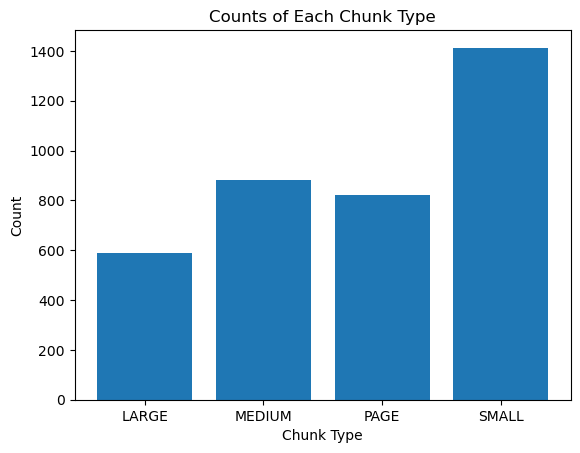

In [43]:
plt.bar(chunk_type.index, chunk_type.values)
plt.xlabel("Chunk Type")
plt.ylabel("Count")
plt.title("Counts of Each Chunk Type")
plt.show()


## Get similar chunks from DB for a given query.
Now we have stored all the chunks in our db. If we have an user query, we can get the most relevant chunks to answer this query. For this we also need to perform the above steps, which we did for each chunks. 
  + preprocess the query 
  + calculate embeddings of the query 

After calculating the embeddings of the user query, we can perform a **Vector Search** to find the most relevant chunks. for this the function <code>get_context_by_chunk_type()</code> is used. This function performes the followin steps,
   + get all the chunks from the database 
   + convert the user query into embeddings 
   + calculate **cosine similarity** of each chunk with the user query.
   + store the chunks in a list
   + sort the list based on similarity score
   + return top 3 relevant chunks as a string

<a id="cell-2"></a>

In [1]:
def get_context_by_chunk_type(chunk_type, query_text):
        start_time = time.time()
        
        # get db connection
        connection = create_connection()
        cursor = connection.cursor()
        cursor.execute(
            "SELECT * FROM text_vectors WHERE chunk_type=%s", (chunk_type,)
        ) 
        
        # get all the chunks
        rows = cursor.fetchall()
        
        # convert user query into vector
        clean_query = preprocess_text(query_text.lower())
        model = SentenceTransformer("all-MiniLM-L6-v2")
        query_vector = model.encode(clean_query)
        
        # calculate cosine similarity 
        similar: list[Similar_Text] = []
        for row in rows:
            sim_score = cosine_similarity(pickle.loads(row[3]), query_vector)
            similar.append(Similar_Text(row[1], sim_score=sim_score))
            
        # sort all the chunks based on similarity score with the user query    
        similar.sort(key=lambda similar: similar.sim_score, reverse=True)
        text = "/n".join([sm.text for sm in similar[:3]])
        end_time = time.time()
        return {"retrieval_time": end_time - start_time, "text": text}

## Generate response by LLM
After getting the relevant chunks from the **Vector Database***, we can send this context + user query as a prompt to the LLM to generate a response. the function [<code>chat_with_ai()</code>](#cell-2) generate response for a given user query. Additionally, the response time is also calculated. 

<a id="cell-2"></a>

In [ ]:
def chat_with_ai(user_query: str, chunk_type, ref_ans):
    # get openai key
    openai_api_key = os.environ["OPENAI_API_KEY"]  
    
    # get relevant chunks
    result = get_context_by_chunk_type(chunk_type, user_query)
    
    # format prompt 
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=result["text"], question=user_query)
    
    # generate response
    model = ChatOpenAI(openai_api_key=openai_api_key, model_name="gpt-4o")
    start_time = time.time()
    response_text = model.invoke(prompt)
    end_time = time.time()
    delta = end_time - start_time
    return {"response_time":delta,"response":response_text.content}

## Used Prompt template

In [ ]:
PROMPT_TEMPLATE = """
            Provide an answer to the question below based exclusively on the Context provided. 
            Do not include information outside of this Context in your response.


            **Context:**
            {context}

            ---------
            **Question:** {question}
 
        """

## Generate Response for 90 user Queries
for analysing the impact of chunk size on the response of LLM I have randomly choosen 90 questions from the dataset. For each question, 4 responses are generated.
 + response for page chunking
 + response for small chunking
 + response for medium chunking
 + response for large chunking

in client the function <code>chat_with_ai()</code> is used to generate a response for a user query.

In [1]:
def chat_with_ai(question, chunk_type,ref_ans):
    # Properly encode parameters separately
    question = requests.utils.quote(question)
    chunk_type = requests.utils.quote(chunk_type)

    # Construct the URL
    url = f"http://127.0.0.1:8080/app/chat/{question}/{chunk_type}/{ref_ans}"

    # Make the request
    response = requests.get(url)
    
    # Return the response as JSON
    if response.status_code == 200:
        return response
    else:
        print("Error:", response.status_code)
        return {"error": "Something went wrong"}

## Generate responses for 90 questions
I have stored all the responses in another Table in my Database. 

In [2]:
for q,ans in zip(questions,answers):
    chunk_type=['PAGE','SMALL','MEDIUM','LARGE'] 
    for c in chunk_type: 
      chat_with_ai(q,c,ans)
   

NameError: name 'questions' is not defined

### Table: evaluate_answer

| Field          | Type                                  | Null | Key | Default | Extra          |
|----------------|---------------------------------------|------|-----|---------|----------------|
| id             | int                                   | NO   | PRI | NULL    | auto_increment |
| ref_answer     | text                                  | YES  |     | NULL    |                |
| chunk_type     | enum('PAGE','SMALL','MEDIUM','LARGE') | NO   |     | NULL    |                |
| llm_response   | text                                  | YES  |     | NULL    |                |
| response_time  | double                                | YES  |     | NULL    |                |
| retrieval_time | double                                | YES  |     | NULL    |                |


<h2 style="text-align:center;color:green">Evaluation Metrics and Analysis</h2>

In [298]:
url = "http://10.54.134.102:8080/app/get/responses"
response = requests.get(url)
response.raise_for_status() 
data = response.json() 
responses_df = pd.DataFrame(data) 

In [309]:
responses_df.head()

,chunk_type,id,llm_response,ref_answer,response_time,retrieval_time
0,PAGE,1,"""Formation"" was released by Beyoncé in Februar...","On February 6, 2016, one day before her Super ...",1.564220,2.501853
1,SMALL,2,"""Unknown based on the Context provided.""","On February 6, 2016, one day before her Super ...",0.875026,1.900175
2,MEDIUM,3,"""The Context provided does not specify when Be...","On February 6, 2016, one day before her Super ...",0.888419,1.369914
3,LARGE,4,"""Based on the provided Context, there is no in...","On February 6, 2016, one day before her Super ...",1.163664,1.433956
4,PAGE,5,"""'03 Bonnie & Clyde""",The music video for '03 Bonnie & Clyde' where ...,0.864547,1.388123


## Analyze <code>response_time</code> and <code>retrieval_time</code>

### Method of Calculating <code>response_time</code> and <code>retrieval_time</code>
**response_time:** It was calculated when the response from the LLM was generated and stored in the <code>evaluate_answer</code> table in seconds in [<code>chat_with_ai()</code>](#cell-2)  function.<br>
**retireval_time:** It was calculated when the relevent chunks were fetched from the database and stored in the <code>evaluate_answer</code> table in seconds in [<code>get_context_by_chunk_type()</code>](#cell-2)  function.

In [263]:
grouped_data = responses.groupby('chunk_type').mean()[['response_time', 'retrieval_time']]

#### function to visualize Response time and Retrieval time

In [278]:
def bar_chart_time_vs_chunk_type(time_type,label):
    
    chunk_types = ["LARGE", "MEDIUM", "PAGE", "SMALL"]
    number_of_chunks = [589, 883, 820, 1413]

    # Create a bar chart for retrieval time
    plt.figure(figsize=(10, 6))

    # Retrieval time bar chart
    plt.bar(grouped_data.index, grouped_data[time_type], color='blue', alpha=0.7, label=f'{label} Time (seconds)')

    # Add a secondary y-axis for number of chunks
    plt.twinx()
    plt.plot(chunk_types, number_of_chunks, color='red', marker='o', linestyle='-', linewidth=2, label='Number of Chunks')

    # Labels and title
    plt.title(f'{label} Time and Number of Chunks by Chunk Type')
    plt.xlabel('Chunk Type')
    plt.ylabel('Response Time (seconds)', color='blue')
    plt.gca().tick_params(axis='y', colors='blue')
    plt.legend(loc="upper left")

    plt.gca().yaxis.set_label_position("right")
    plt.ylabel('Number of Chunks', color='green')
    plt.gca().tick_params(axis='y', colors='green')

    plt.show()
    

### Response Time

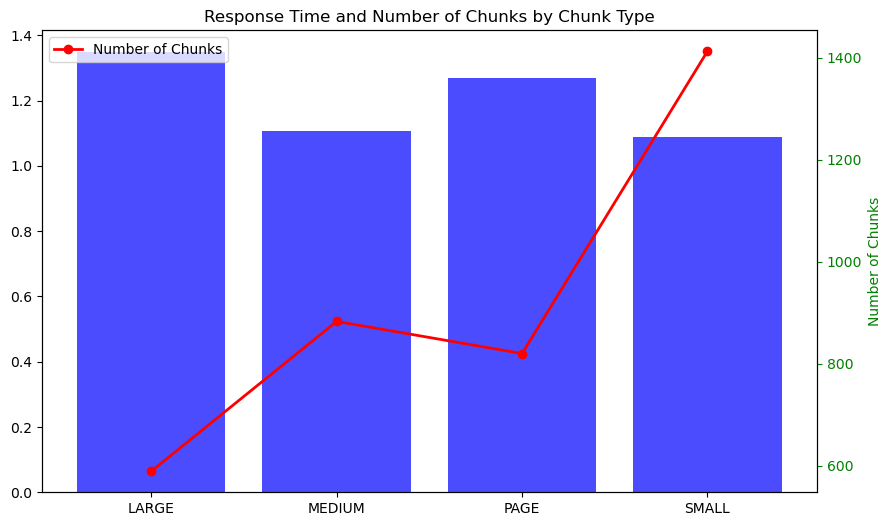

In [279]:
bar_chart_time_vs_chunk_type("response_time","Response")

+ The average response time varies across chunk types.
+ Smaller chunks (e.g., "SMALL" and "MEDIUM") tend to have slightly lower response times, as the LLM has less context to process.
+ Larger chunks ("PAGE" and "LARGE") require more processing, resulting in longer response times.

### Retrieval time

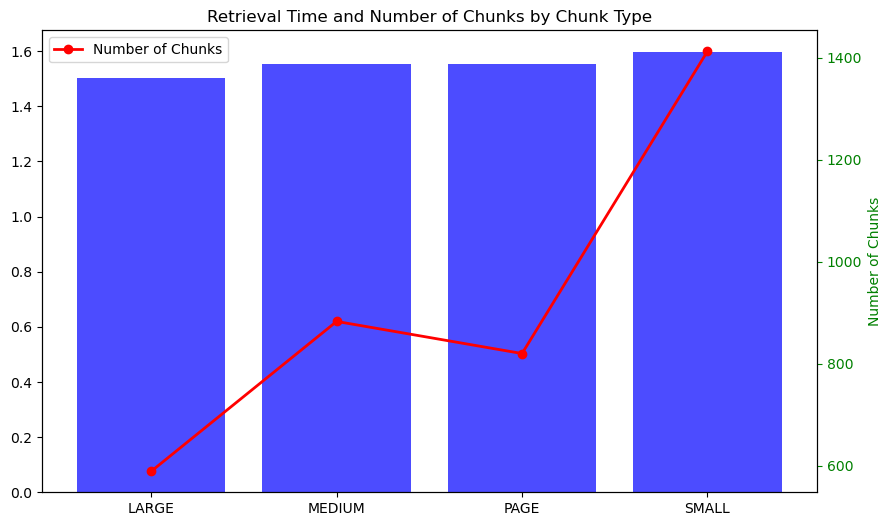

In [280]:
bar_chart_time_vs_chunk_type("retrieval_time","Retrieval")

### Distribution of time in Retrieval Process: 
[<code>get_context_by_chunk_type()</code>](#cell-2) function was used for as a retriever. the retrieval preocess performs mainly three tasks.

+ **Database Query:** The time to fetch rows from the database scales with the number of chunks in each chunk type. Smaller chunk types (e.g., "SMALL") involve more rows, increasing the query processing time.
+ **Cosine Similarity Computation:** The number of similarity calculations increases linearly with the number of chunks. With 1413 chunks for "SMALL," this step takes significantly longer compared to "LARGE," which only has 589 chunks.
+ **Sorting Overhead:** Sorting a larger list (e.g., 1413 chunks for "SMALL") adds marginal computational overhead compared to smaller lists.


### Small Differences Between MEDIUM and PAGE:
+ Retrieval times for MEDIUM (883 chunks) and PAGE (820 chunks) are very close. **This indicates:** The time spent fetching and processing these chunks is relatively stable within a certain range.


### Small Chunks Have the Highest Overhead:

+ SMALL chunks (1413) lead to the longest retrieval time because:
    + They involve the most rows fetched from the database.
    + They require the most cosine similarity calculations.

### Larger Chunks Are More Efficient:

 + LARGE chunks (589) result in the shortest retrieval time because fewer rows are fetched and fewer similarity calculations are needed.
 + This suggests that the retrieval system benefits from handling fewer, larger chunks rather than many smaller ones.


### Impact of Number of Chunks on Retrieval Time:

+ Retrieval time increases with the number of chunks to be processed.
+ The SMALL chunk type has the highest number of chunks (1413) and also exhibits the longest retrieval time.
+ Conversely, the LARGE chunk type, with the fewest chunks (589), has the shortest retrieval time.

### Uniform Chunk Dimensions:

+ All chunks have the same dimension(1,384) because they were generated using a Sentence Transformer model. This means the computational effort for encoding chunks is consistent across chunk types, regardless of their content length.

**Summary of Retrieval Time Trends:**

| Chunk Type | Retrieval Time (seconds) | Number of Chunks | Reason for Trend                                                                 |
|------------|---------------------------|------------------|---------------------------------------------------------------------------------|
| SMALL      | 1.591126                 | 1413             | Highest retrieval time due to the largest number of chunks and cosine similarity calculations. |
| MEDIUM     | 1.554785                 | 883              | Moderate retrieval time; fewer chunks than SMALL but still significant computation. |
| PAGE       | 1.552313                 | 820              | Similar to MEDIUM; slightly fewer chunks but close retrieval time.             |
| LARGE      | 1.528357                 | 589              | Lowest retrieval time due to the smallest number of chunks and computational requirements. |



### Method of Analyzing Generated Responses.
Evaluating LLM-generated responses manually is inefficient at scale. After observing the generated responses I have divided them in 4 categories. The categories are:
+ **1: Accurately answers the question** -> the question could be completely answered by llm.  
+ **2: Partially answers the question** -> Part of the question could be answerd by the model. for **example**: **ref_answer:**"On February 6, 2016, one day before her Super Bowl performance.", **llm_response:** "Formation" was released by Beyoncé in February 2016." we can see that the year of the formation could be identified by the model but the date was not given. 
+ **3: Cannot answer from the context** -> an appropriate context to answer the question was not found in the given context. This happens when the Vector search result was wrong. From this count we will later estimate the **retrieval accuracy**. In this cases the llm_responses were -> ""The Context provided does not specify when Beyoncé released her single 'Formation'." or "Unknown based on the provided context." 
+ **4: Unrelated to the reference answer**. -> The answer provided by the llm is totally wrong or unrealeted to the ref_answer. This happens may for noisy context or biasness of the model. **example**: **ref_answer**:"The film Knute Rockne, All American featured this scene.", **llm_response**: "Airplane!"

In cases **2** and **4** hallucination is observed, and the type of hallucination will be identified separately. However, case **3** indicates that the relevant context could not be found within the information provided to the LLM, suggesting a failure in vector search or a retrieval issue.

### Prompt to evaluate llm_response with ref_answer

In [217]:
# Define your dynamic ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_messages([
    HumanMessagePromptTemplate.from_template(
        """
You are tasked with evaluating the quality of a single response generated by a language model (LLM). 
Each evaluation involves a question, a reference answer, and one LLM-generated response. Your job is to evaluate
the response based on the criteria provided below.

---

### **Evaluation Criteria**
1. **Answer Accuracy**:
   - **1**: The response answers the question accurately.
   - **2**: The response partially answers the question.
   - **3**: The response cannot answer the question from the given context.
   - **4**: The response answers the question but is completely unrelated to the reference answer.

2. **Hallucination Type**:
   - **N/A** if **Answer Accuracy** = 1 or 3.
   - If **Answer Accuracy** = 2 or 4, classify the hallucination type as:
     - **Intrinsic**: The response is incomplete or incorrect due to limitations in the generative model (e.g.,
     biases, insufficient reasoning).
     - **Extrinsic**: The response is incomplete or incorrect due to reliance on irrelevant, incomplete, or 
     noisy retrieval from the context.
     - **Intrinsic Extrinsic**: Both intrinsic and extrinsic factors contribute to the hallucination.

---

### **Examples**

#### **Example 1**
- **Question:** What title did People magazine award Beyoncé in 2012?
- **Reference Answer:** People magazine named her the 'World's Most Beautiful Woman' in 2012.
- **LLM Response:** "Based exclusively on the Context provided, the title People magazine awarded Beyoncé in 2012 is not mentioned."

**Example Output 2**:
{{
    "answer_accuracy": 3,
    "hallucination_type": "N/A"
}} 
#### **Example 2**
- **Question:** What title did People magazine award Beyoncé in 2012?
- **Reference Answer:** People magazine named her the 'World's Most Beautiful Woman' in 2012.
- **LLM Response:** "Sexiest Woman of the 21st Century""

**Example Output 2**:
{{
    "answer_accuracy": 4,
    "hallucination_type": "Intrinsic"
}} 
### Your output must be in JSON Format.
### Output Format:
{{
    "answer_accuracy": 1/2/3/4,
    "hallucination_type": "Intrinsic"/"N/A"/"Extrinsic"/"Extrinsic Intrinsic"
}}
### Inputs:
- **Question:** {question}
- **Reference Answer:** {reference_answer}
- **LLM Responses:**
    {response}
  
"""
    )
])


### evaluate the generated responses with reference responses

In [ ]:
openai_api_key =key
gpt_evaluations=[]
for ref_answer, llm_response in zip(responses['ref_answer'], responses['llm_response']):
            inputs = {
            "question": questions[answers.index(ref_answer)],
            "reference_answer": ref_answer,
            "response": llm_response ,
           }
            formatted_prompt = prompt_template.format(**inputs)
            model = ChatOpenAI(openai_api_key=openai_api_key, model_name="gpt-4o")
            response_text = model.invoke(formatted_prompt)
            gpt_evaluations.append(response_text)
            time.sleep(5)
        

#### example row response

In [282]:
print(gpt_evaluations[0])

content='```json\n{\n    "answer_accuracy": 2,\n    "hallucination_type": "Intrinsic"\n}\n```' response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 572, 'total_tokens': 596, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_c7ca0ebaca', 'finish_reason': 'stop', 'logprobs': None} id='run-1f1fdcd8-9b18-4e78-8dbb-b3bafe63afee-0' usage_metadata={'input_tokens': 572, 'output_tokens': 24, 'total_tokens': 596}


#### example response in JSON Format

In [284]:
print(json.loads(gpt_evaluations[0].content.strip().replace("```json", "").replace("```", "").strip()))

{'answer_accuracy': 2, 'hallucination_type': 'Intrinsic'}


#### extract all the <code>answer_accuracies</code> and <code>hallucination_types</code>  from llm responses and store them in a list for further use.

In [236]:
# Initialize empty lists for answer_accuracy and hallucination_type
answer_accuracies = []
hallucination_types = []

for evaluation in gpt_evaluations:
    try:
        # Strip out the markdown code block delimiters
        content = evaluation.strip() if isinstance(evaluation, str) else evaluation.content.strip().replace("```json", "").replace("```", "").strip()
        content_in_json = json.loads(content)
        answer_accuracies.append(content_in_json['answer_accuracy'])
        hallucination_types.append(content_in_json['hallucination_type'])
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        print(f"Invalid Content")



In [237]:
answer_accuracies[:5],hallucination_types[:5]

([2, 3, 3, 3, 1], ['Intrinsic', 'N/A', 'N/A', 'N/A', 'N/A'])

### create two new columns in <code>evaluation_sheet</code> to store in <code>answer_accuracy</code> and <code>hallucination_type</code>  for further analysis

In [239]:
responses['answer_accuracy'] = answer_accuracies
responses['hallucination_type'] = hallucination_types

### Analyze Hallucination

In [313]:
# Filter out rows with "N/A" in the "hallucination_type" column
filtered_data = responses[responses["hallucination_type"] != "N/A"]

# Group by "chunk_type" and "hallucination_type" to count occurrences
hallucination_analysis = filtered_data.groupby(["chunk_type", "hallucination_type"]).size().unstack(fill_value=0)
hallucination_analysis

hallucination_type,Extrinsic,Intrinsic,Intrinsic Extrinsic
chunk_type,,,
LARGE,2,27,2
MEDIUM,3,32,2
PAGE,1,19,2
SMALL,0,24,3


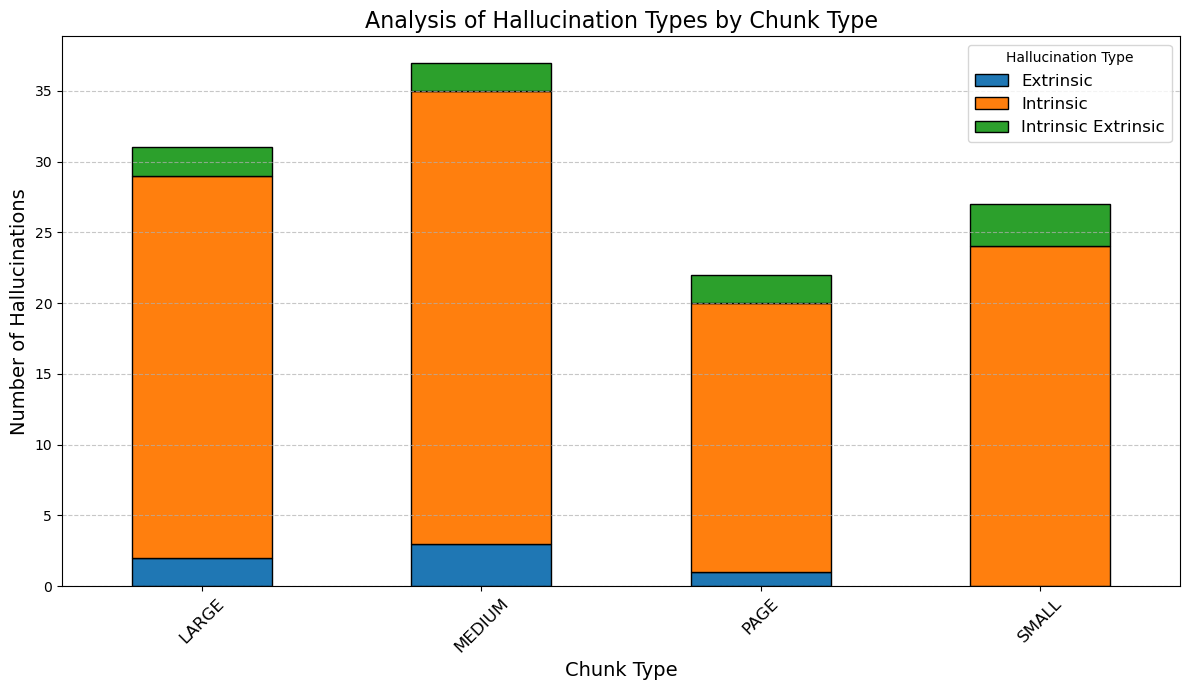

In [314]:

hallucination_analysis.plot(kind="bar", stacked=True, figsize=(12, 7), edgecolor='black')
plt.title("Analysis of Hallucination Types by Chunk Type", fontsize=16)
plt.xlabel("Chunk Type", fontsize=14)
plt.ylabel("Number of Hallucinations", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Hallucination Type", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



### Intrinsic Hallucinations Dominate:

+ Across all chunk types, intrinsic hallucinations are the most frequent. This suggests the model's generative reasoning is a key area for improvement.

### Chunk Size Matters:

+ SMALL chunks seem to handle retrieval well (no extrinsic hallucinations) but still struggle with intrinsic hallucinations, possibly due to limited context.
+ PAGE chunks also perform well with minimal extrinsic hallucinations but exhibit slightly fewer intrinsic hallucinations compared to MEDIUM and LARGE chunks.

### Trade-off Between Chunk Size and Accuracy:

+ MEDIUM and LARGE chunks show more hallucinations overall, likely due to the complexity introduced by handling larger contexts.

### store the updated evaluation sheet as excel for further analysis

In [310]:
responses.to_excel('evaluation_sheet_v2.xlsx', index=False)

In [311]:
responses.shape

(356, 8)

In [2]:
responses=pd.read_excel('evaluation_sheet_v2.xlsx')
responses.shape

(360, 8)

## Retrieval Metrics Analysis

we have two **Retrieval Metrics**:
$$\frac{}{}
$$

$$
\text{Precision} = \frac{\text{Relevant Chunks}}{\text{Total Retrieved Chunks}}
$$



$$
\text{Recall} = \frac{\text{Relevant Chunks}}{\text{Total Relevant Chunks in Knowledge Base}}
$$


<code>answer_accuracy</code> **3** means the relevant context was totally not found in the given context. That's mean in the cases completely irrelevant chunks were retrieved. 

#### Number of irrelevant chunks retrieved in each chunk type

In [315]:
responses[responses['answer_accuracy'].isin([3])].groupby("chunk_type")['id'].count()

chunk_type
LARGE     18
MEDIUM    15
PAGE      12
SMALL     18
Name: id, dtype: int64

#### Number of relevant chunks retrieved in each chunk type

In [316]:
responses[responses['answer_accuracy'].isin([1,2,4])].groupby("chunk_type")['id'].count()

chunk_type
LARGE     72
MEDIUM    75
PAGE      78
SMALL     72
Name: id, dtype: int64

### Calculating precision and recall

In [317]:

irrelevant_chunks = pd.Series({'LARGE': 18, 'MEDIUM': 15, 'PAGE': 12, 'SMALL': 18}, name="Irrelevant Chunks")
relevant_chunks = pd.Series({'LARGE': 72, 'MEDIUM': 75, 'PAGE': 78, 'SMALL': 72}, name="Relevant Chunks")

# Total retrieved chunks
total_retrieved_chunks = irrelevant_chunks + relevant_chunks

# Calculating Precision
precision = relevant_chunks / total_retrieved_chunks

# Calculating Recall
total_relevant_chunks_in_kb = relevant_chunks.sum()
recall = relevant_chunks / total_relevant_chunks_in_kb

# Combine into a DataFrame for better visualization
retrieval_metrics = pd.DataFrame({
    'Irrelevant Chunks': irrelevant_chunks,
    'Relevant Chunks': relevant_chunks,
    'Total Retrieved Chunks': total_retrieved_chunks,
    'Precision': precision,
    'Recall': recall
})



In [318]:
retrieval_metrics

,Irrelevant Chunks,Relevant Chunks,Total Retrieved Chunks,Precision,Recall
LARGE,18,72,90,0.800000,0.242424
MEDIUM,15,75,90,0.833333,0.252525
PAGE,12,78,90,0.866667,0.262626
SMALL,18,72,90,0.800000,0.242424


## visualize Precision and Recall

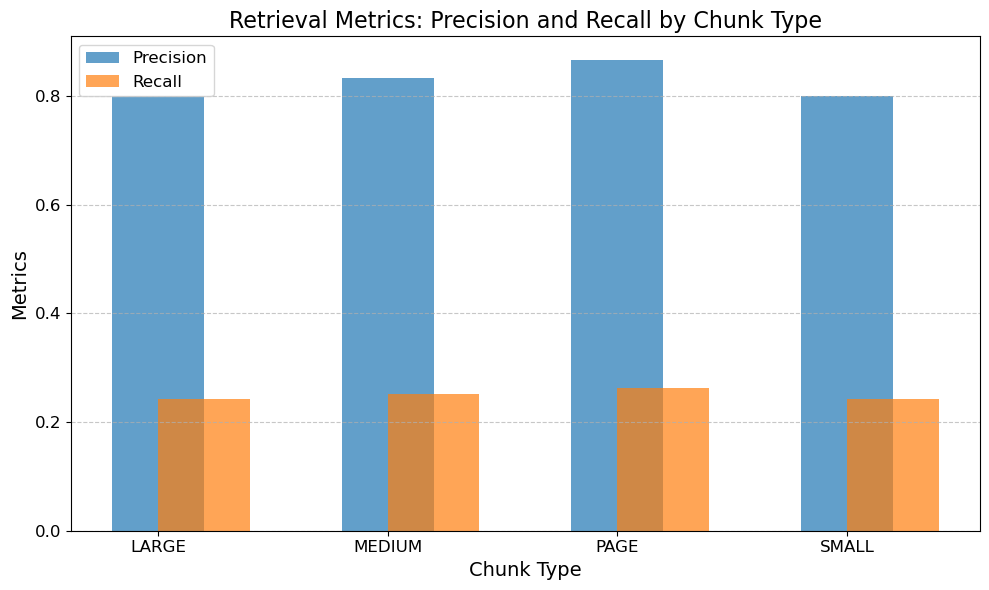

In [319]:

# Data for visualization
chunk_types = ['LARGE', 'MEDIUM', 'PAGE', 'SMALL']
precision = retrieval_metrics['Precision']
recall = retrieval_metrics['Recall']

# Plot Precision and Recall
plt.figure(figsize=(10, 6))

# Plot precision
plt.bar(chunk_types, precision, width=0.4, label='Precision', alpha=0.7, align='center')

# Plot recall
plt.bar(chunk_types, recall, width=0.4, label='Recall', alpha=0.7, align='edge')

# Add titles and labels
plt.title('Retrieval Metrics: Precision and Recall by Chunk Type', fontsize=16)
plt.xlabel('Chunk Type', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


### Precision Interpretation:
+ PAGE (0.866667) has the highest precision, meaning it retrieves the highest proportion of relevant chunks while minimizing irrelevant chunks.
+ MEDIUM (0.833333) follows closely in precision, performing slightly better than LARGE and SMALL.
+ LARGE and SMALL (0.800000 each) have the lowest precision, indicating they retrieve a higher proportion of irrelevant chunks compared to PAGE and MEDIUM.

### Recall Interpretation:
+ PAGE (0.262626) achieves the highest recall, showing it captures the largest proportion of relevant chunks from the knowledge base.
+ MEDIUM (0.252525) is second, indicating good recall but slightly less than PAGE.
+ LARGE and SMALL (0.242424 each) have the lowest recall, suggesting they miss more relevant chunks compared to PAGE and MEDIUM.

# Contextual Accuracy Analyze

## ROUGE-1 Score Calculation

In [7]:

def rouge1(ref,candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1'],use_stemmer=True)
    result = scorer.score(ref,candidate)
    return result

In [13]:
result = rouge1("The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend.",
                "03 Bonnie & Clyde")
result

{'rouge1': Score(precision=1.0, recall=0.2, fmeasure=0.33333333333333337)}

In [14]:
result = rouge1("The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend.",
                "Drunk in Love")
result

{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0)}

In [11]:
responses[responses['ref_answer']=="The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend."]

,chunk_type,id,llm_response,ref_answer,response_time,retrieval_time,answer_accuracy,hallucination_type
4,PAGE,5,"""'03 Bonnie & Clyde""",The music video for '03 Bonnie & Clyde' where ...,0.864547,1.388123,1,NaN
5,SMALL,6,"""'03 Bonnie & Clyde""",The music video for '03 Bonnie & Clyde' where ...,2.525418,2.372649,1,NaN
6,MEDIUM,7,"""Pretty Hurts""",The music video for '03 Bonnie & Clyde' where ...,0.684017,1.981795,4,Intrinsic
7,LARGE,8,"""Drunk in Love""",The music video for '03 Bonnie & Clyde' where ...,1.131651,1.565581,4,Intrinsic


#  ROUGE1 Score Calculation for Given Reference and Candidate



### Inputs:
1. **Reference (Reference Text)**:  
   `"The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend."`
2. **Candidate (Summarized Text)**:  
   `"03 Bonnie & Clyde"`

---

### Step 1: Normalize tokens (remove punctuation, apply stemming)
- **Reference Tokens**:  
  `['03', 'Bonnie', '&', 'Clyde', 'music', 'video', 'for', 'the', 'where', 'Beyoncé', 'appeared', 'as', 'Jay', 'Z', 'girlfriend']`
- **Candidate Tokens**:  
  `['03', 'Bonnie', '&', 'Clyde']`

---

### Step 2: Count Overlapping Unigrams
- **Overlap Tokens**:  
  `['03', 'Bonnie', '&', 'Clyde']`  
  **Number of Overlaps**: `4`

---


### Step 3: Calculate Precision, Recall, and F1 Score
1. **Precision**:  
   $$
   \text{Precision} = \frac{\text{Number of overlapping unigrams}}{\text{Number of unigrams in candidate}}
   $$ 
   $$
   \text{Precision} = \frac{4}{4} = 1.0
  $$

2. **Recall**:  
 $$
   \text{Recall} = \frac{\text{Number of overlapping unigrams}}{\text{Number of unigrams in reference}}
 $$
$$
   \text{Recall} = \frac{4}{15} = 0.2
   $$

3. **F1 Score**:  
j$$
   \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
   $$
   $$
   \text{F1} = 2 \cdot \frac{0.2 \cdot 1.0}{0.2 + 1.0}\approx 0.336
  $$
---

## Analyze <code>ROUGE1</code> Score for all the llm reponses.
When evaluating the contextual accuracy of the LLM responses, we will focus only on the responses where the LLM made an attempt to answer the question. Specifically, we will exclude responses categorized as **3**, where the LLM could not even attempt an answer due to the lack of relevant context. Instead, we will consider responses in categories **1**, **2**, and **4** for our analysis, as these indicate an effort was made to address the question.

In [17]:
relevent_llm_responses =responses[responses['answer_accuracy'].isin([1,2,4])] 

In [18]:
relevent_llm_responses.shape

(297, 8)

In [19]:

precisions=[]
recallls=[]
fmeasures=[]
for ref,candidate in zip(relevent_llm_responses['ref_answer'],relevent_llm_responses['llm_response']):
        result = rouge1(ref,candidate)
        precisions.append(result['rouge1'].precision) 
        recallls.append(result['rouge1'].recall)
        fmeasures.append(result['rouge1'].fmeasure)
        

In [21]:
t_d = pd.DataFrame({'chunk_type':relevent_llm_responses['chunk_type'],'precision':precisions,'recall':recallls,'fmeasure':fmeasures})

In [25]:
summary_rouge1 = t_d.groupby('chunk_type').agg(
    mean_precision=('precision', 'mean'),
    mean_recall=('recall', 'mean'),
    mean_fmeasure=('fmeasure', 'mean'),
    chunk_count=('chunk_type', 'count')
).reset_index()

In [26]:
summary_rouge1

,chunk_type,mean_precision,mean_recall,mean_fmeasure,chunk_count
0,LARGE,0.533499,0.494349,0.431011,72
1,MEDIUM,0.551352,0.448447,0.423448,75
2,PAGE,0.645766,0.586535,0.528191,78
3,SMALL,0.649957,0.518165,0.494537,72


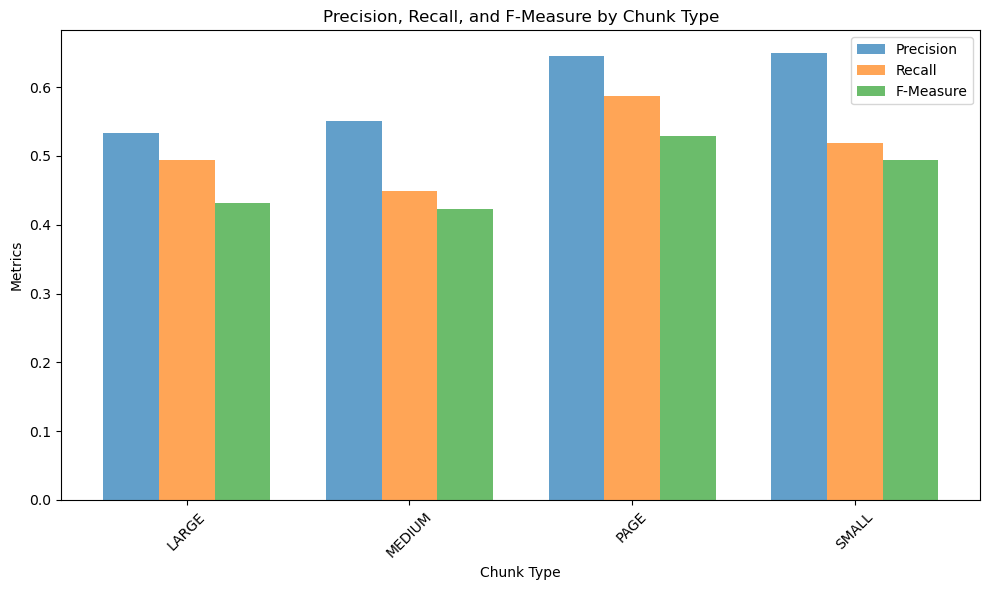

In [29]:
x = np.arange(len(summary_rouge1['chunk_type']))  # Label locations
width = 0.25  # Width of the bars

# Plot each metric as separate bars
plt.figure(figsize=(10, 6))
plt.bar(x - width, summary_rouge1['mean_precision'], width, label='Precision', alpha=0.7)
plt.bar(x, summary_rouge1['mean_recall'], width, label='Recall', alpha=0.7)
plt.bar(x + width, summary_rouge1['mean_fmeasure'], width, label='F-Measure', alpha=0.7)

# Customize the plot
plt.title('Precision, Recall, and F-Measure by Chunk Type')
plt.xlabel('Chunk Type')
plt.ylabel('Metrics')
plt.xticks(x, summary_rouge1['chunk_type'], rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

+ Precision is highest for SMALL and PAGE chunks, indicating the model performs better when given smaller or well-defined contexts.
+ Recall is highest for PAGE chunks, suggesting broader contexts help the model capture more relevant details.
+ Precision is highest for SMALL and PAGE chunks, indicating the model performs better when given smaller or well-defined contexts.
+ Recall is highest for PAGE chunks, suggesting broader contexts help the model capture more relevant details.
+ LARGE and MEDIUM chunks have the lowest f-measure scores, highlighting that the model struggles more with these chunk sizes, likely due to more dispersed or complex information.

# BLEU Score Calculation

In [43]:
def remove_special_chars(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

In [31]:
def bleu_score(reference: str, candidate: str) -> float:
 
    # Tokenize the reference and candidate
    reference_tokens = [reference.split()]  # Reference must be a list of token lists
    candidate_tokens = candidate.split()  # Candidate is tokenized

    # Apply smoothing to handle edge cases
    smoothing_function = SmoothingFunction().method1

    # Calculate BLEU score
    bleu = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothing_function)

    return bleu

The <code>sentence_bleu()</code> function doesn’t automatically normalize text, which can lead to lower scores. Normalizing the text beforehand often improves the **BLEU score**.

## bleu score with normalization

In [44]:
bleu_score(remove_special_chars("The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend."),
                                remove_special_chars("03 Bonnie & Clyde"))

0.01437430645724448

## bleu score without normalization

In [45]:
bleu_score("The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend.",
                                "03 Bonnie & Clyde")

0.010861626466864211

# BLEU Score Calculation for Given Reference and Candidate

## Inputs
1. **Reference Text**:  
   `"The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend."`  
   - Tokenized: `['The', 'music', 'video', 'for', "'03", 'Bonnie', '&', "Clyde'", 'where', 'Beyoncé', 'appeared', 'as', 'Jay', "Z's", 'girlfriend.']`
   - Length: 15 tokens.

2. **Candidate Text**:  
   `"03 Bonnie & Clyde"`  
   - Tokenized: `['03', 'Bonnie', '&', 'Clyde']`
   - Length: 4 tokens.

---

## BLEU Formula
The BLEU score is calculated as:
$$
BLEU = BP \cdot \exp \left( \sum_{n=1}^N w_n \cdot \log p_n \right)
$$
Where:
- \( BP \): Brevity penalty
- \( p_n \): Precision of n-grams
- \( w_n \): Weight for each n-gram precision (typically uniform, \( w_n = \frac{1}{N} \))
- \( N \): Maximum n-gram length (default is 4)

---

## Step 1: Calculate n-gram Precision (\( p_n \))

### **1-grams (unigrams)**:
- Candidate: `['03', 'Bonnie', '&', 'Clyde']`
- Reference: `['The', 'music', 'video', 'for', "'03", 'Bonnie', '&', "Clyde'", ..., 'girlfriend.']`
- Overlapping 1-grams: `['03', 'Bonnie', '&']`  
  **Count**: 3  
  **Precision**:  
  $$
  p_1 = \frac{\text{Count of matching 1-grams}}{\text{Total 1-grams in candidate}} = \frac{3}{4} = 0.75
  $$

### **2-grams**:
- Candidate: `['03 Bonnie', 'Bonnie &', '& Clyde']`
- Reference: Sliding 2-grams from reference: `['The music', 'music video', ..., 'Bonnie &', '& Clyde\'']`
- Overlapping 2-grams: `['Bonnie &']`  
  **Count**: 1  
  **Precision**:  
  $$
  p_2 = \frac{\text{Count of matching 2-grams}}{\text{Total 2-grams in candidate}} = \frac{1}{3} = 0.333
  $$

### **3-grams**:
- Candidate: `['03 Bonnie &', 'Bonnie & Clyde']`
- Reference: Sliding 3-grams from reference: `['The music video', 'music video for', ..., 'Bonnie & Clyde\'']`
- Overlapping 3-grams: `None`  
  **Count**: 0  
  **Precision**:  
  $$
  p_3 = \frac{0}{2} = 0.0
  $$

### **4-grams**:
- Candidate: `['03 Bonnie & Clyde']`
- Reference: Sliding 4-grams from reference: `['The music video for', 'music video for \'03', ..., 'Bonnie & Clyde\'']`
- Overlapping 4-grams: `None`  
  **Count**: 0  
  **Precision**:  
  $$
  p_4 = \frac{0}{1} = 0.0
  $$

---

## Step 2: Brevity Penalty (\( BP \))
Brevity penalty accounts for the length mismatch between candidate and reference text:
$$
BP = 
\begin{cases} 
1 & \text{if } c > r \\ 
e^{(1 - r/c)} & \text{if } c \leq r 
\end{cases}
$$
Where:
- \( c \): Length of candidate (number of tokens) = 4
- \( r \): Length of reference (number of tokens) = 15

Here:
$$
BP = e^{(1 - \frac{15}{4})} = e^{-2.75} \approx 0.063
$$

---

## Step 3: Weighted Logarithmic Precision
Using \( w_n = 0.25 \) for each \( n \) (uniform weights):
$$
\sum_{n=1}^4 w_n \cdot \log p_n = \frac{1}{4} \cdot (\log 0.75 + \log 0.333 + \log 0.0 + \log 0.0)
$$
Since \( \log 0 \) is undefined, BLEU introduces smoothing. For example, very low scores are replaced with small nonzero values.

---

## Step 4: Final BLEU Calculation
Finally:
$$
BLEU = BP \cdot \exp \left( \sum_{n=1}^N w_n \cdot \log p_n \right)
$$
With \( BP \approx 0.063 \), the brevity penalty dominates, and the final BLEU score is approximately:
$$
BLEU \approx 0.011
$$

---

## Conclusion:
- The BLEU score is very low (\( \approx 0.011 \)).
- This is due to:
  1. **Short candidate text**: Brevity penalty significantly reduces the score.
  2. **Low n-gram overlap**: Few matches beyond 1-grams.
- BLEU is designed for longer, structured outputs, making short candidates like this one score poorly.


# Analyze <code>BLEU</code> Score for all the llm reponses.

In [47]:
bleu_scores=[]
for ref,candidate in zip(relevent_llm_responses['ref_answer'],relevent_llm_responses['llm_response']):
        result = bleu_score(remove_special_chars(ref),remove_special_chars(candidate))
        bleu_scores.append(result)

In [49]:
t_d = pd.DataFrame({'chunk_type':relevent_llm_responses['chunk_type'],'bleu_scores':bleu_scores})

In [51]:
t_d.groupby('chunk_type')['bleu_scores'].mean()

chunk_type
LARGE     0.174304
MEDIUM    0.190198
PAGE      0.222143
SMALL     0.207249
Name: bleu_scores, dtype: float64

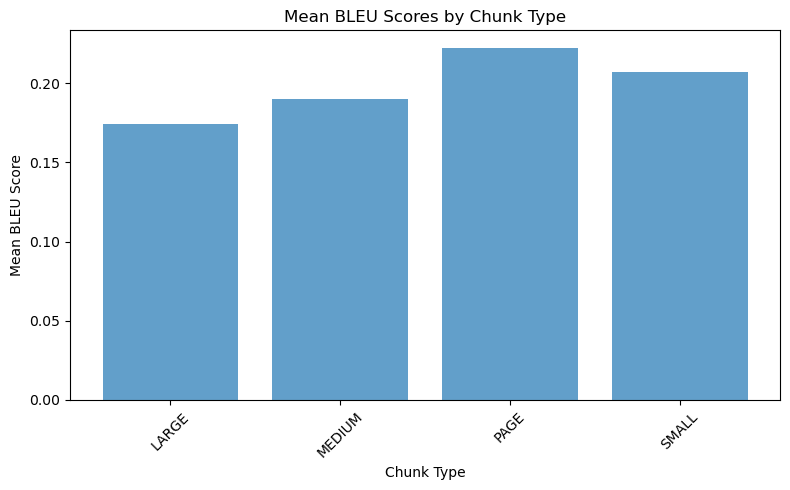

In [52]:
mean_bleu_scores = t_d.groupby('chunk_type')['bleu_scores'].mean().reset_index()

# Plot the mean BLEU scores
plt.figure(figsize=(8, 5))
plt.bar(mean_bleu_scores['chunk_type'], mean_bleu_scores['bleu_scores'], alpha=0.7)
plt.title('Mean BLEU Scores by Chunk Type')
plt.xlabel('Chunk Type')
plt.ylabel('Mean BLEU Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

+ **LARGE:** Lowest BLEU score (0.174), suggesting difficulty in aligning larger chunks with references.
+ **MEDIUM:** Slightly better (0.190), showing improved alignment with medium chunks.
+ **SMALL:** Higher BLEU score (0.207), indicating better alignment for smaller chunks.
+ **PAGE:** Best BLEU score (0.222), suggesting the model performs best when handling page-level chunks with broader context.<br>


Overall, performance improves as the chunk size becomes more contextually balanced (PAGE and SMALL perform better).

# BertScore Analyze

# Why BERTScore is Better than ROUGE-1 and BLEU

### Example Reference:  
> "The quick brown fox jumps over the lazy dog."

### Candidates:  
1. **Candidate 1 (Synonyms)**:  
   > "The fast brown fox leaps over the lazy hound."
2. **Candidate 2 (Paraphrased)**:  
   > "A lazy dog is jumped over by a speedy brown fox."

---

## Comparison:

### 1. **ROUGE-1**:
- Counts unigram overlap but fails to capture synonyms (`"quick"` vs. `"fast"`) and penalizes paraphrasing or reordering.

### 2. **BLEU**:
- Measures n-gram overlap but penalizes missing exact matches and reordering heavily.
- Fails to capture semantic similarity (e.g., `"jumps"` vs. `"leaps"`).

### 3. **BERTScore**:
- Uses semantic embeddings to capture synonyms and paraphrases effectively.
- Handles reordering (`"A lazy dog is jumped over by..."`) without significant penalty.

---

## Summary Table:

| Metric     | Candidate 1 (Synonyms) | Candidate 2 (Paraphrased) |
|------------|-------------------------|---------------------------|
| **ROUGE-1** | Moderate                | Higher                   |
| **BLEU**    | Low                     | Moderate                 |
| **BERTScore** | High                  | High                     |

---

## Conclusion:
BERTScore outperforms ROUGE-1 and BLEU when dealing with:
- **Synonyms** (`"quick"` = `"fast"`, `"jumps"` = `"leaps"`),
- **Paraphrasing**, and
- **Word Reordering**.

This makes BERTScore more robust and closer to human judgment for text similarity evaluation.


In [55]:
def bert_score(ref: str, candidate: str):
  
    # BERTScore requires inputs as lists of strings
    references = [ref]
    candidates = [candidate]

    # Calculate BERTScore
    result = score(candidates, references, lang="en", verbose=False)

    # Return the F1 score as a float
    return result

# BERTScore Calculation: Explanation with Normalized Inputs

## Inputs After Normalization
**Reference**:  
`"The music video for 03 Bonnie Clyde where Beyoncé appeared as Jay Zs girlfriend"`  
Tokenized (example):  
`['The', 'music', 'video', 'for', '03', 'Bonnie', 'Clyde', 'where', 'Beyoncé', 'appeared', 'as', 'Jay', 'Zs', 'girlfriend']`

**Candidate**:  
`"03 Bonnie Clyde"`  
Tokenized (example):  
`['03', 'Bonnie', 'Clyde']`

---

## Steps for Calculation

### Step 1: Tokenization
Tokens are created for both the reference and candidate using the tokenizer for `roberta-large`.

---

### Step 2: Embedding Generation
Contextual embeddings are generated for each token using `roberta-large`.  
For example:
- `"03"` in the **candidate** and `"03"` in the **reference** are mapped to dense vectors that encode their contextual meanings.

---

### Step 3: Cosine Similarity
Pairwise cosine similarities are computed between all tokens in the **candidate** and **reference**. For each token in the candidate:
1. Find its **maximum similarity** across all reference tokens.

Example (hypothetical):
- `"03"` → Max similarity with `"03"` in reference: 0.95
- `"Bonnie"` → Max similarity with `"Bonnie"` in reference: 0.92
- `"Clyde"` → Max similarity with `"Clyde"` in reference: 0.90

---

### Step 4: Calculate Precision and Recall

#### **Precision**
Average the maximum similarity scores for each token in the **candidate**:
$$
\text{Precision} = \frac{1}{|\text{Candidate Tokens}|} \sum_{\text{token}_c \in \text{Candidate}} \max_{\text{token}_r \in \text{Reference}} \text{Similarity}(\text{token}_c, \text{token}_r)
$$

Example:
$$
\text{Precision} = \frac{0.95 + 0.92 + 0.90}{3} = 0.92
$$

**Result**:
$$
\text{Precision} \approx 0.9181
$$

#### **Recall**
Average the maximum similarity scores for each token in the **reference**:
$$
\text{Recall} = \frac{1}{|\text{Reference Tokens}|} \sum_{\text{token}_r \in \text{Reference}} \max_{\text{token}_c \in \text{Candidate}} \text{Similarity}(\text{token}_r, \text{token}_c)
$$

Example:
$$
\text{Recall} = \frac{\text{(Sum of max similarities)}}{\text{Number of Reference Tokens}}
$$

**Result**:
$$
\text{Recall} \approx 0.8106
$$

---

### Step 5: Compute F1 Score
The F1 Score is calculated as:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Using:
- Precision = 0.9181
- Recall = 0.8106

$$
\text{F1} = 2 \cdot \frac{0.9181 \cdot 0.8106}{0.9181 + 0.8106} \approx 0.8610
$$

---

## Final Results
- **Precision**: 0.9181  
- **Recall**: 0.8106  
- **F1 Score**: 0.8610


In [65]:
bert_score("The music video for '03 Bonnie & Clyde' where Beyoncé appeared as Jay Z's girlfriend.",
                                "03 Bonnie & Clyde")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.9221]), tensor([0.8268]), tensor([0.8719]))

In [69]:
precisions=[]
recallls=[]
fmeasures=[]
for ref,candidate in zip(relevent_llm_responses['ref_answer'],relevent_llm_responses['llm_response']):
        result = bert_score(ref,candidate)
        precisions.append(result[0].item()) 
        recallls.append(result[1].item())
        fmeasures.append(result[2].item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [70]:
t_d = pd.DataFrame({'chunk_type':relevent_llm_responses['chunk_type'],'precision':precisions,'recall':recallls,'fmeasure':fmeasures})

In [71]:
summary_rouge1 = t_d.groupby('chunk_type').agg(
    mean_precision=('precision', 'mean'),
    mean_recall=('recall', 'mean'),
    mean_fmeasure=('fmeasure', 'mean'),
    chunk_count=('chunk_type', 'count')
).reset_index()
summary_rouge1

,chunk_type,mean_precision,mean_recall,mean_fmeasure,chunk_count
0,LARGE,0.884297,0.896317,0.889839,72
1,MEDIUM,0.882737,0.892760,0.887348,75
2,PAGE,0.896008,0.909695,0.902371,78
3,SMALL,0.894369,0.902984,0.898220,72


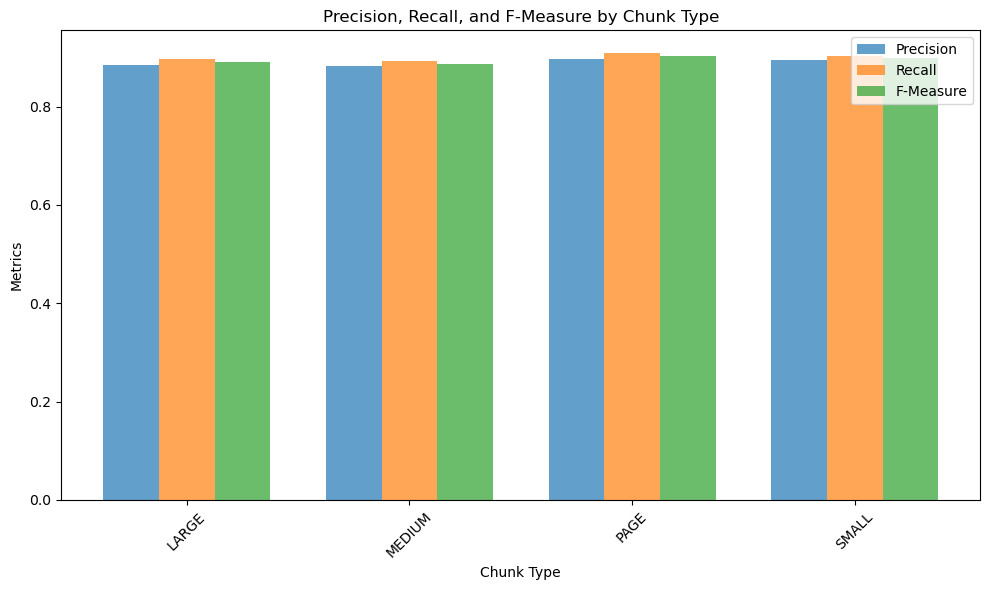

In [72]:
x = np.arange(len(summary_rouge1['chunk_type']))  # Label locations
width = 0.25  # Width of the bars

# Plot each metric as separate bars
plt.figure(figsize=(10, 6))
plt.bar(x - width, summary_rouge1['mean_precision'], width, label='Precision', alpha=0.7)
plt.bar(x, summary_rouge1['mean_recall'], width, label='Recall', alpha=0.7)
plt.bar(x + width, summary_rouge1['mean_fmeasure'], width, label='F-Measure', alpha=0.7)

# Customize the plot
plt.title('Precision, Recall, and F-Measure by Chunk Type')
plt.xlabel('Chunk Type')
plt.ylabel('Metrics')
plt.xticks(x, summary_rouge1['chunk_type'], rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()